In [1]:
#-- For data handling
import xarray as xr
import pandas as pd
import numpy as np
#-- For plotting
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
#-- lanczos filter
from oceans.filters import lanc
#-- for EOFs
from eofs.xarray import Eof
from scipy import signal
#-- for regridding
import xesmf as xe

# Open tas MIROC6 files through opendap

In [2]:
tas1 = xr.open_dataset('http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/Amon/tas/gn/v20181212/tas_Amon_MIROC6_historical_r1i1p1f1_gn_185001-194912.nc', decode_times=True)
tas2 = xr.open_dataset('http://esgf-data2.diasjp.net/thredds/dodsC/esg_dataroot/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/Amon/tas/gn/v20181212/tas_Amon_MIROC6_historical_r1i1p1f1_gn_195001-201412.nc', decode_times=True)
tas = xr.concat([tas1,tas2], dim='time')

# Seasonal means

In [3]:
# Seasonal mean
tas_seas = tas['tas'].groupby('time.season').mean('time') - 273.15

# Quick plot with xarray

/srv/conda/envs/notebook/lib/python3.6/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


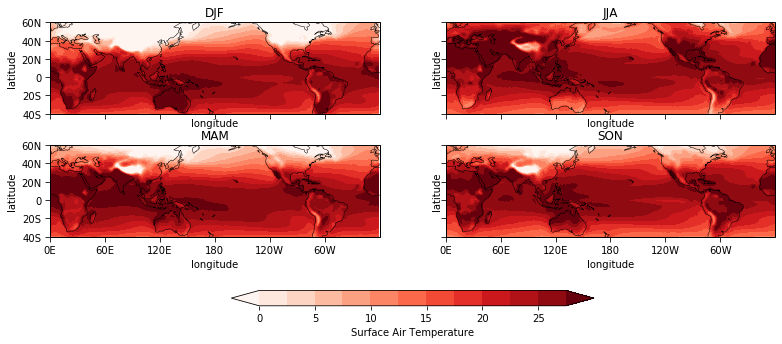

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(13,4),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180.0)),sharex = True, sharey = True)
ax = ax.flatten()

cmap = plt.get_cmap('Reds')
for itr,axi in enumerate(ax) :
    
    cf = tas_seas.isel(season=itr).plot.contourf(ax=axi, cmap=cmap, transform=ccrs.PlateCarree(),extend="both", add_colorbar = False,
                                           levels=np.arange(0,30,2.5))

    limits = (0,359,-40,60)
    xaxis_interval = 60
    yaxis_interval = 20
 
    axi.coastlines(linewidth=0.5)
    axi.set_title(tas_seas.isel(season=itr)['season'].values)
    axi.set_extent(limits)
    axi.set_xticks(np.arange(limits[0],limits[1]+1,xaxis_interval), crs=ccrs.PlateCarree())
    axi.set_yticks(np.arange(limits[2],limits[3]+1,yaxis_interval), crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True, degree_symbol='')
    lat_formatter = LatitudeFormatter(degree_symbol='')
    axi.xaxis.set_major_formatter(lon_formatter)
    axi.yaxis.set_major_formatter(lat_formatter)
    axi.tick_params(direction = 'out', length = 5)
    axi.set_aspect('equal', 'box')
    axi.set_xlabel('longitude')
    axi.set_ylabel('latitude')

cbar = fig.colorbar(cf,ax = ax, orientation = 'horizontal',extendfrac='auto', shrink=0.5, anchor=(0.5,-4), label = 'Surface Air Temperature',)
plt.subplots_adjust(hspace=0.3)
plt.savefig('tas_seasons.png', orientation='landscape',dpi=100)

# Selection per slice and position


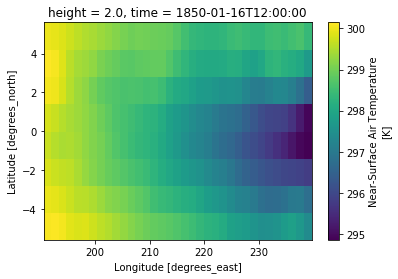

In [5]:
nino34_area = tas.sel(lat=slice(-5,5), lon=slice(190,240))
nino34_area['tas'].isel(time=0).plot()

# NINO3.4 index

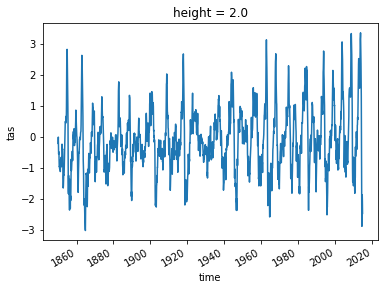

In [6]:
baseline = nino34_area.sel(time=slice('1961','1990'))
baseline_average = baseline.groupby('time.month').mean(dim='time')

anomaly = nino34_area.groupby('time.month') - baseline_average
nino34_index = anomaly.mean(dim=('lat','lon'))
nino34_index['tas'].plot()

# Resampling

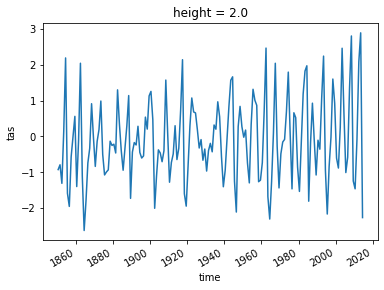

In [7]:
nino34_index_6M = nino34_index.resample(time='6MS').mean().sel(time = slice('1850-06','2014-12',2))
nino34_index_6M.tas.plot()
ntime = nino34_index_6M.dims['time']

# Detrending using polyfit


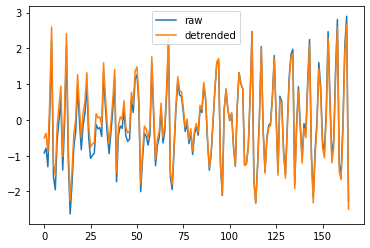

In [8]:
z = np.polyfit(x = np.arange(ntime), y = nino34_index_6M.tas, deg = 2)
zza = np.polyval(z,np.arange(ntime))
plt.plot(nino34_index_6M.tas, label='raw')
plt.plot(nino34_index_6M.tas-zza, label='detrended')
plt.legend()

# Lowpass filter

In [9]:
freq = 1./13  
window_size = 13
pad = np.zeros(window_size) * np.NaN

wt = lanc(window_size, freq)
lowpass = np.convolve(wt, nino34_index_6M.tas - zza, mode='same')

# NINO3.4 pretty plot

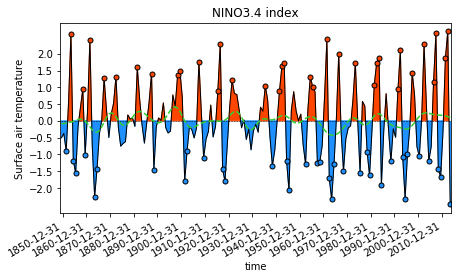

In [10]:
nino34_index_plot = nino34_index_6M.tas - zza
fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(3.50394*2,3.50394))

nino34_index_plot.plot(color='black', linewidth = 1)
plt.fill_between(nino34_index_plot.time.to_index(), 0, nino34_index_plot, where=nino34_index_plot > 0, interpolate=True, color = 'orangered')
plt.fill_between(nino34_index_plot.time.to_index(), 0, nino34_index_plot, where=nino34_index_plot < 0, interpolate=True, color = 'dodgerblue')


nino34_index_elnino = nino34_index_plot[nino34_index_plot > 0.8 * np.std(nino34_index_plot)]
plt.plot(nino34_index_elnino.time.to_index(),nino34_index_elnino, marker = 'o', linestyle = 'None', color = 'orangered', markersize = 5, markeredgecolor = 'black')
nino34_index_lanina = nino34_index_plot[nino34_index_plot < -0.8 * np.std(nino34_index_plot)]
plt.plot(nino34_index_lanina.time.to_index(),nino34_index_lanina, marker = 'o', linestyle = 'None', color = 'dodgerblue', markersize = 5, markeredgecolor = 'black')
plt.plot(nino34_index_plot.time.to_index(), np.repeat(0,ntime), linewidth = 0.5, linestyle ='--', color='black')
plt.ylabel('Surface air temperature')
plt.yticks(np.arange(-2,2.5,0.5))
plt.xticks(pd.date_range(start='1850',end = '2014', freq ='10Y'))
plt.xlim([pd.datetime(1850,1,1),pd.datetime(2014,12,31)])
plt.title('NINO3.4 index')

plt.plot(nino34_index_plot.time.to_index(),lowpass, color='limegreen', linestyle ='--')
plt.savefig('nino3.4.png', orientation='portrait', bbox_inches="tight", dpi = 200)

# ENSO & IPO empirical orthogonal functions

In [18]:
# Regrid
grid_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)), 'lon': (['lon'], np.arange(0, 360, 1.5))})

regridder = xe.Regridder(tas, grid_out, 'bilinear')
tas_regrid = regridder(tas['tas'])

Overwrite existing file: bilinear_128x256_120x240.nc 
 You can set reuse_weights=True to save computing time.


In [29]:
tsbox = tas_regrid.sel(lat=slice(-40,60), lon=slice(0,360))

# remove seasonal cycle
mon_avg = tsbox.groupby('time.month').mean(dim='time')
anomaly = tsbox.groupby('time.month') - mon_avg
# june to december averages
anomaly_jundec = anomaly.sel(time = slice('1850-06','2014-12') ).resample(time='6MS').mean(dim='time').sel(time = slice('1850-06','2014-12',2))
# detrend
anomaly_jundec_detrend = signal.detrend(anomaly_jundec, axis = 0)
anomaly_jundec_detrend = xr.DataArray(np.transpose(anomaly_jundec_detrend, axes = [0,1,2]), 
                                      dims={'time': 165, 'lat': 67, 'lon': 240},
                                      coords = anomaly_jundec.coords)
# land sea mask
mask = xr.open_dataset("fractional_land.1.5-deg.nc").sel(lat=slice(-40,60), lon=slice(0,360))
mask50 = mask['data'].where( mask['data'] > 0.5, 0)
maske = np.repeat(mask50.values,165, axis = 0)
anomaly_jundec_detrend_masked = anomaly_jundec_detrend.where(maske == 0, 0)

In [35]:
res = np.apply_along_axis(lambda m: np.convolve(wt, m, mode='same'), axis=0, arr=anomaly_jundec)
res = xr.DataArray(res, dims=anomaly_jundec.dims, coords = anomaly_jundec.coords)
# land sea mask
maske = np.repeat(mask50.values,165, axis = 0)
anomaly_jundec_lowpass_masked = res.where(maske == 0, 0)

In [36]:
# eofs for low pass filtered
solver_lowpass = Eof(anomaly_jundec_lowpass_masked)
pcs_lowpass = solver_lowpass.pcs(npcs=4)
eofs_lowpass = solver_lowpass.eofs(neofs=4)
eigenvalue1_lowpass = solver_lowpass.eigenvalues(neigs=4)
variance_fractions_lowpass = solver_lowpass.varianceFraction(neigs=4)
# eof for raw detrended data
solver = Eof(anomaly_jundec_detrend_masked)
pcs = solver.pcs(npcs=4)
eofs = solver.eofs(neofs=4)
eigenvalue1 = solver.eigenvalues(neigs=4)
variance_fractions = solver.varianceFraction(neigs=4)

# Plot detrended EOFs : ENSO

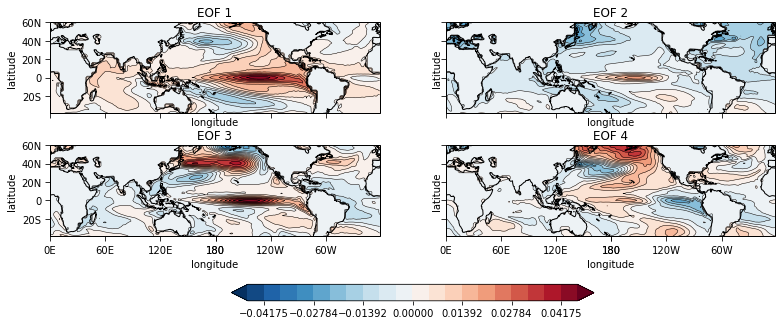

In [52]:
fig, ax = plt.subplots(2, 2, figsize=(13,4),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180.0)),sharex = True, sharey = True)
ax = ax.flatten()

cmap = plt.get_cmap('RdBu_r')

maxi = np.max([abs(eofs.min()),eofs.max()])
vmin = -maxi
vmax = maxi
nb_interval = 20
projection=ccrs.PlateCarree()
sature_minmax='both'
add_contour_lines = True
title = 'EOF'+str(itr+1)
coastlines = True
colorbar = True
colorbar_orientation = 'vertical'
shrink=1
limits = (-180,179.9,-40,60)
xaxis_interval = 60
yaxis_interval = 20

for itr,axi in enumerate(ax) :

    cf = eofs.sel(mode=itr).plot.contourf(ax=axi, levels=np.linspace(vmin , vmax , nb_interval + 1), cmap=cmap, 
                      transform=projection, extend=sature_minmax, add_colorbar = False)
    
    if add_contour_lines :
        eofs.sel(mode=itr).plot.contour(ax=axi,levels=np.linspace(vmin , vmax , nb_interval + 1), 
                     transform=projection, extend=sature_minmax, colors = 'black', linestyles = '-', linewidths = 0.5, add_colorbar = False)
        
    axi.set_title('EOF %s' % (itr+1))

    if coastlines :
        axi.coastlines(linewidth=1.)
    
    if axi.projection.__class__ != ccrs.Robinson().__class__ :
        if limits == None :
            limits = (min(longitude.values),max(longitude.values),min(latitude.values),max(latitude.values))
        axi.set_xticks(np.arange(limits[0],limits[1]+1,xaxis_interval), crs=ccrs.PlateCarree())
        axi.set_yticks(np.arange(limits[2],limits[3]+1,yaxis_interval), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True, degree_symbol='')
        lat_formatter = LatitudeFormatter(degree_symbol='')
        axi.xaxis.set_major_formatter(lon_formatter)
        axi.yaxis.set_major_formatter(lat_formatter)
        axi.tick_params(direction = 'out', length = 5)
        axi.set_aspect('equal', 'box')
        axi.set_xlabel('longitude')
        axi.set_ylabel('latitude')
        
cbar = fig.colorbar(cf,ax = ax, orientation = 'horizontal',extendfrac='auto', shrink=0.5, anchor=(0.5,-4))
plt.subplots_adjust(hspace=0.3)

#plt.tight_layout()
#plt.savefig('eofs.png', orientation='landscape',dpi=100)

# Plot lowpass filter EOFs : IPO

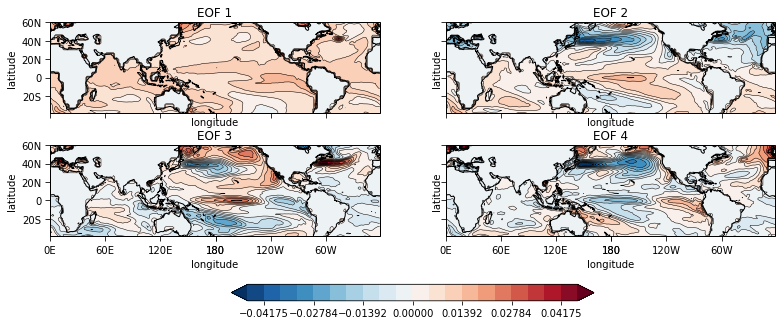

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(13,4),subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180.0)),sharex = True, sharey = True)
ax = ax.flatten()

cmap = plt.get_cmap('RdBu_r')

maxi = np.max([abs(eofs.min()),eofs.max()])
vmin = -maxi
vmax = maxi
nb_interval = 20
projection=ccrs.PlateCarree()
sature_minmax='both'
add_contour_lines = True
title = 'EOF'+str(itr+1)
coastlines = True
colorbar = True
colorbar_orientation = 'vertical'
shrink=1
limits = (-180,179.9,-40,60)
xaxis_interval = 60
yaxis_interval = 20

for itr,axi in enumerate(ax) :

    cf = eofs_lowpass.sel(mode=itr).plot.contourf(ax=axi, levels=np.linspace(vmin , vmax , nb_interval + 1), cmap=cmap, 
                      transform=projection, extend=sature_minmax, add_colorbar = False)
    
    if add_contour_lines :
        eofs_lowpass.sel(mode=itr).plot.contour(ax=axi,levels=np.linspace(vmin , vmax , nb_interval + 1), 
                     transform=projection, extend=sature_minmax, colors = 'black', linestyles = '-', linewidths = 0.5, add_colorbar = False)
        
    axi.set_title('EOF %s' % (itr+1))

    if coastlines :
        axi.coastlines(linewidth=1.)
    
    if axi.projection.__class__ != ccrs.Robinson().__class__ :
        if limits == None :
            limits = (min(longitude.values),max(longitude.values),min(latitude.values),max(latitude.values))
        axi.set_xticks(np.arange(limits[0],limits[1]+1,xaxis_interval), crs=ccrs.PlateCarree())
        axi.set_yticks(np.arange(limits[2],limits[3]+1,yaxis_interval), crs=ccrs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True, degree_symbol='')
        lat_formatter = LatitudeFormatter(degree_symbol='')
        axi.xaxis.set_major_formatter(lon_formatter)
        axi.yaxis.set_major_formatter(lat_formatter)
        axi.tick_params(direction = 'out', length = 5)
        axi.set_aspect('equal', 'box')
        axi.set_xlabel('longitude')
        axi.set_ylabel('latitude')
        
cbar = fig.colorbar(cf,ax = ax, orientation = 'horizontal',extendfrac='auto', shrink=0.5, anchor=(0.5,-4))
plt.subplots_adjust(hspace=0.3)

#plt.tight_layout()
#plt.savefig('eofs.png', orientation='landscape',dpi=100)